In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns

from scipy.stats import pearsonr

sns.set_style("darkgrid")
np.random.seed(930525)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)

warnings.simplefilter('once')

%matplotlib inline
%load_ext watermark
%watermark --iversions

seaborn 0.10.1
numpy   1.18.4
pandas  1.1.4



In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
import shap

import pandas as pd
import requests

from io import StringIO

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [3]:
from collections import defaultdict

url = requests.get('https://docs.google.com/spreadsheets/d/1xqhFLsQplNUu5k9Uxv7DgTwftCiE78E0JmsKvNi0Ft4/export?format=csv')
csv_raw = StringIO(url.text)
df_truth = pd.read_csv(csv_raw)

inf_tax_file = "/mnt/btrfs/data/gtdb_95/gtdb_genomes_reps_r95/r95.gtdb.tax"

In [4]:
df_truth["results"] = 0

In [5]:
df_list = []

column_names = ["assembly_accession", "dataset", "query", "species"]


for t in df_truth.itertuples():
    query = t.homotypic_synonym
    results = !rg {query} {inf_tax_file}
    set_results = set()
    if len(results) > 0:
        for r in results:
            split = r.split("\t")
            set_results.add((split[0], ";".join(split[1].split(";")[:7])))
    queries = query.split("_")
    
    set_0 = !rg {queries[0]} {inf_tax_file}
    set_0 = set(set_0)
    set_1 = !rg {queries[1]} {inf_tax_file}
    set_1 = set(set_1)

    intersection = set_0.intersection(set_1)
    if len(intersection) > 0:
        for r in results:
            split = r.split("\t")
            set_results.add((split[0], ";".join(split[1].split(";")[:7])))
            
    for set_result in set_results:
        df_list.append((set_result[0], t.dataset, query, set_result[1]))
        
df_queries = pd.DataFrame(df_list, columns=column_names)

In [11]:
dd_dataset2assembly_accessions = defaultdict(set)
for dataset, df in df_queries.groupby('dataset'):
    for assembly_accession in df['assembly_accession']:
        dd_dataset2assembly_accessions[dataset].add(assembly_accession)

# Building the true species dataset

In [7]:
df_tax = pd.read_csv(inf_tax_file, names=["assembly_accession", "tax"], sep="\t")

df_tax["species"] = [";".join(_.split(";")[:7]) for _ in df_tax.tax]
df_tax["genus"] = [";".join(_.split(";")[:6]) for _ in df_tax.tax]
df_tax["family"] = [";".join(_.split(";")[:5]) for _ in df_tax.tax]

In [85]:
from glob import glob
import os

files = glob("/mnt/btrfs/data/type_1/species_mc/b6_split_by_sample/*extra.tree.csv")

dfs = []
for file in files:
    name = '_'.join(os.path.basename(file).split('.')[:-4])
    print(name)
    if name == "test_sort":
        continue
    df = pd.read_csv(file, index_col = 0)
    df['dataset'] = name
    dfs.append(df)
df_type_1_features = pd.concat(dfs)

dual_index
test_sort
zymo_even


Columns (87,91,100,109) have mixed types.Specify dtype option on import or set low_memory=False.


mbarc_26
zymo_log


Columns (73,86,98,99,103,106,107,111,112,204,217,229,230,234,237,238,242,243) have mixed types.Specify dtype option on import or set low_memory=False.


hmp_staggered
hmp_even
gis_20


In [86]:
t.dataset

'gis_20'

In [88]:
# dd_dataset2assembly_accessions[t.dataset]

In [89]:
rows = []
for t in df_type_1_features.itertuples():
    if t.assembly_accession in dd_dataset2assembly_accessions[t.dataset]:
        rows.append(True)
    else:
        rows.append(False)
df_type_1_features["truth"] = rows

In [90]:
df_type_1_features.groupby('truth').mean()

,tree_dist,tree_top_dist,hits,percent_coverage,mean_coverage,sd_coverage,percent_padded_coverage,mean_padded_coverage,sd_padded_coverage,percent_binned_coverage,...,tree_gf_mean_scaffold_length,tree_gf_n50_contigs,tree_gf_n50_scaffolds,tree_gf_protein_count,tree_gf_scaffold_count,tree_gf_ssu_count,tree_gf_total_gap_length,tree_gf_trna_aa_count,tree_gf_trna_count,tree_gf_trna_selenocysteine_count
truth,,,,,,,,,,,,,,,,,,,,,
False,0.125241,1.930559,4274.256707,0.001388,0.146213,2.574139,0.002033,0.216675,3.779058,0.002678,...,8.058297e+05,1.093596e+06,1.249987e+06,3819.533090,76.287868,2.157170,9817.586091,19.337721,51.749032,0.160963
True,0.032882,1.435644,535532.544554,0.165590,22.813896,42.461948,0.221359,36.838603,62.525642,0.260928,...,1.826575e+06,2.435759e+06,2.537457e+06,3119.866337,23.698020,4.207921,3708.311881,19.603960,58.267327,0.222772


In [91]:
df_type_1_features.groupby('dataset').mean()

,tree_dist,tree_top_dist,hits,percent_coverage,mean_coverage,sd_coverage,percent_padded_coverage,mean_padded_coverage,sd_padded_coverage,percent_binned_coverage,...,tree_gf_n50_contigs,tree_gf_n50_scaffolds,tree_gf_protein_count,tree_gf_scaffold_count,tree_gf_ssu_count,tree_gf_total_gap_length,tree_gf_trna_aa_count,tree_gf_trna_count,tree_gf_trna_selenocysteine_count,truth
dataset,,,,,,,,,,,,,,,,,,,,,
dual_index,0.120691,1.989008,108.931851,0.001763,0.005549,0.052780,0.002234,0.006904,0.071412,0.002870,...,1.129564e+06,1.294797e+06,3807.313737,69.550468,2.265561,10889.223855,19.431568,52.481377,0.155392,0.002136
gis_20,0.118821,1.896445,19236.332607,0.002178,0.587648,11.457486,0.002843,0.894531,16.041987,0.003693,...,1.127082e+06,1.277582e+06,3916.328516,77.123373,2.143669,6616.306147,19.360873,51.803942,0.162744,0.001753
hmp_even,0.132927,1.831895,1205.671267,0.002222,0.027150,0.670012,0.003703,0.075910,1.370516,0.004653,...,1.036182e+06,1.183016e+06,3798.242926,83.113132,2.005308,9276.677129,19.196538,50.275467,0.163720,0.001754
hmp_staggered,0.132350,1.850019,664.930262,0.001119,0.013075,0.456796,0.002148,0.042195,0.998040,0.002964,...,1.057824e+06,1.207405e+06,3821.154354,81.732126,2.043972,9402.177458,19.252472,50.632297,0.167380,0.001806
mbarc_26,0.116898,2.056123,6640.071598,0.002374,0.445560,1.222147,0.002614,0.416823,1.181332,0.003119,...,1.135078e+06,1.306175e+06,3898.536280,79.262254,2.324745,12627.015178,19.385977,54.081964,0.177699,0.002147
zymo_even,0.122589,1.984238,625.484874,0.001166,0.029422,0.303774,0.001548,0.035656,0.372526,0.002037,...,1.106914e+06,1.267416e+06,3743.073659,69.400121,2.226796,10587.274386,19.409942,52.195089,0.148348,0.000909
zymo_log,0.126145,1.982295,8035.484096,0.000805,0.252670,3.925084,0.001280,0.515691,6.302995,0.001824,...,1.110680e+06,1.269649e+06,3750.678970,69.803925,2.229324,10524.154483,19.405714,52.059537,0.152263,0.000900


In [92]:
features = ['hits',
 'percent_coverage',
 'mean_coverage',
 'sd_coverage',
 'percent_binned_coverage',
 'mean_binned_coverage',
 'sd_binned_coverage',
 'expected_percent_coverage',
 'shannon_entropy',
 'percent_max_uncovered_region',
 'largest_pileup',
 'largest_binned_pileup',
 'gc_content',
 'total_genome_length',
 'ungapped_genome_length',
 'num_n_groups',
 'consecutive_ns',
 'tree_dist',
 'tree_top_dist',
 'gf_checkm_completeness',
 'gf_checkm_contamination'
]

In [47]:
# df_type_1_features[~np.isfinite(df_type_1_features['shannon_entropy'])]

In [48]:
# df_type_1_features[~np.isfinite(df_type_1_features['percent_coverage'])]

In [95]:
from sklearn.model_selection import PredefinedSplit

In [107]:
df_type_1_features.reset_index(drop=True, inplace=True)
df_type_1_features['dataset_cat'] = pd.Series([_.split("_")[0] for _ in df_type_1_features['dataset']], dtype='category')

In [108]:
df_type_1_features['dataset_cat'].value_counts()

hmp      42701
zymo     33157
gis      18821
dual     15921
mbarc    13506
Name: dataset_cat, dtype: int64

In [111]:
X_type_1 = df_type_1_features[features + ["assembly_accession", "dataset", "truth", "dataset_cat"]]
                                                 
X_type_1 = X_type_1.replace([np.inf, -np.inf], np.nan)
X_type_1 = X_type_1.dropna()

print(X_type_1.groupby('dataset').sum())

y = X_type_1["truth"]
cv = PredefinedSplit(X_type_1['dataset_cat'].cat.codes)
X = X_type_1.loc[:, X_type_1.columns.difference(["assembly_accession", "dataset", "truth", "dataset_cat"])]

                    hits  percent_coverage  mean_coverage    sd_coverage  \
dataset                                                                    
dual_index       1734304         28.062051      88.341678     840.304259   
gis_20         362047016         40.984396   11060.117565  215641.336241   
hmp_even        26120868         48.138912     588.211176   14515.805304   
hmp_staggered   13987473         23.541141     275.052218    9609.165257   
mbarc_26        89680807         32.067000    6017.729981   16506.313587   
zymo_even       10317373         19.231281     485.308514    5010.760035   
zymo_log       133887236         13.417510    4209.986755   65399.745693   

               percent_binned_coverage  mean_binned_coverage  \
dataset                                                        
dual_index                     45.7004              173.4298   
gis_20                         69.5042            36204.6297   
hmp_even                      100.7977             2612.079

In [112]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import f1_score

In [120]:
classifiers = []
results = []
for i, (train, test) in enumerate(cv.split(X)):
    clf = RandomForestClassifier(bootstrap=True, class_weight="balanced_subsample", criterion="gini", max_features=0.6000000000000001, min_samples_leaf=9, min_samples_split=9, n_estimators=100)
    clf.fit(X.loc[train], y.loc[train])
    classifiers.append(clf)
    y_pred = clf.predict(X.loc[test])
    results.append(f1_score(y.loc[test], y_pred))
    print(results)

[0.4888888888888888]
[0.4888888888888888, 0.28865979381443296]
[0.4888888888888888, 0.28865979381443296, 0.2732919254658385]
[0.4888888888888888, 0.28865979381443296, 0.2732919254658385, 0.27450980392156865]
[0.4888888888888888, 0.28865979381443296, 0.2732919254658385, 0.27450980392156865, 0.4421052631578948]


In [123]:
mask_misses = y.loc[test] != y_pred

In [129]:
tps

21

In [164]:
tps = y.loc[test][y_pred] == True
fps = y.loc[test][y_pred] == False
tns = y.loc[test][~y_pred] == False
fns = y.loc[test][~y_pred] == True

In [165]:
print(tps.sum())
print(fps.sum())
print(tns.sum())
print(fns.sum())

21
44
33083
9


In [166]:
fns.sum()

9

In [167]:
X_type_1.loc[fps[fps].index]

,hits,percent_coverage,mean_coverage,sd_coverage,percent_binned_coverage,mean_binned_coverage,sd_binned_coverage,expected_percent_coverage,shannon_entropy,percent_max_uncovered_region,...,num_n_groups,consecutive_ns,tree_dist,tree_top_dist,gf_checkm_completeness,gf_checkm_contamination,assembly_accession,dataset,truth,dataset_cat
16015,244739,0.637328,10.263798,14.546428,0.8149,24.4739,29.721731,0.999965,4.321106,0.013369,...,17,20,0.007,1.0,99.75,0.27,GCA_000332645.1,zymo_even,False,zymo
16237,42077,0.095586,1.337664,11.217053,0.2310,4.2077,29.786436,0.737542,0.889164,0.018277,...,0,0,0.004,2.0,99.26,0.17,GCF_001660175.1,zymo_even,False,zymo
16722,54910,0.159305,1.552899,9.610460,0.3868,5.4910,25.890788,0.788366,1.314720,0.031742,...,3,20,0.006,1.0,100.00,0.73,GCF_900478215.1,zymo_even,False,zymo
16778,12215,0.051990,0.416758,4.393627,0.1356,1.2215,10.226575,0.340819,0.501993,0.009867,...,42,20,0.006,2.0,99.26,0.07,GCF_002900365.1,zymo_even,False,zymo
19015,25473,0.108666,1.480426,11.013573,0.2004,2.5472,16.653083,0.772459,0.994315,0.010869,...,16,20,0.012,2.0,99.45,0.00,GCA_000183865.1,zymo_even,False,zymo
19207,12185,0.029082,0.496794,8.872857,0.0660,1.2185,20.015103,0.391522,0.322489,0.024461,...,14,20,0.006,1.0,98.69,1.05,GCF_000245335.1,zymo_even,False,zymo
19460,31215,0.055325,1.874504,17.287693,0.0937,3.1215,27.169139,0.846569,0.611381,0.024947,...,1,20,0.009,1.0,99.51,0.36,GCF_002902405.1,zymo_even,False,zymo
20424,23521,0.097846,0.846768,5.356982,0.2169,2.3521,11.763814,0.571201,0.878942,0.013597,...,0,0,0.010,3.0,98.94,0.10,GCF_000759775.1,zymo_even,False,zymo
21374,24191,0.095206,1.440117,9.165651,0.1531,2.4191,13.919549,0.763100,0.932800,0.016450,...,101,50,0.009,1.0,99.63,0.36,GCF_000236925.1,zymo_even,False,zymo
21508,42077,0.095586,1.337664,11.217053,0.2310,4.2077,29.786436,0.737542,0.889164,0.018277,...,0,0,0.002,1.0,99.26,0.17,GCF_004211955.1,zymo_even,False,zymo


In [158]:
fns

array([False, False, False,  True,  True, False, False, False, False,
        True, False, False, False, False,  True, False, False, False,
       False, False, False,  True, False,  True,  True,  True,  True,
       False, False, False])

In [168]:
for assembly_accession in X_type_1.loc[tps[tps].index, 'assembly_accession']:
    print(df_tax.query(f'assembly_accession == "{assembly_accession}"')['tax'].values[0])

k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas_aeruginosa
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Listeriaceae;g__Listeria;s__Listeria_monocytogenes
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Listeriaceae;g__Listeria;s__Listeria_monocytogenes_C
k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus_subtilis_G
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia_coli_C
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Listeriaceae;g__Listeria;s__Listeria_monocytogenes_B
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia_coli_D
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Salmonella;s__Salmonella_enterica
k__Bacteria;p__Proteobacteria;c__Gam

In [163]:
for assembly_accession in X_type_1.loc[fns[fns].index, 'assembly_accession']:
    print(df_tax.query(f'assembly_accession == "{assembly_accession}"')['tax'].values[0])

k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Limosilactobacillus;s__Limosilactobacillus_fermentum_A
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Limosilactobacillus;s__Limosilactobacillus_fermentum
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas_aeruginosa_A
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus;s__Enterococcus_faecalis
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Limosilactobacillus;s__Limosilactobacillus_fermentum
k__Bacteria;p__Firmicutes;c__Bacilli;o__Staphylococcales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus_aureus
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Listeriaceae;g__Listeria;s__Listeria_monocytogenes
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Limosilactobacillus;s__Limosilactobacillu

In [154]:
for assembly_accession in X_type_1.loc[fps[fps].index, 'assembly_accession']:
    print(df_tax.query(f'assembly_accession == "{assembly_accession}"')['tax'].values[0])

k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus_inaquosorum
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia_sp001660175
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Salmonella;s__Salmonella_houtenae
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia_marmotae
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Listeriaceae;g__Listeria;s__Listeria_marthii
k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus_mojavensis
k__Bacteria;p__Firmicutes;c__Bacilli;o__Staphylococcales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus_schweitzeri
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia_albertii
k__Bacteria;p__Firmicutes;c__B

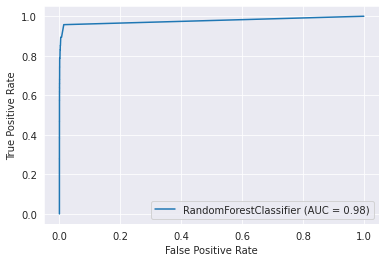

In [116]:
clf_disp = plot_roc_curve(clf, X_type_1_test, y_test)
plt.show()

In [ ]:
# X_type_1["truth"] = y
# sns.pairplot(X_type_1, hue="truth")

In [ ]:
# explainer = shap.TreeExplainer(clf, X_type_1_train)

# shap_values = explainer.shap_values(X_type_1_train)
# shap.summary_plot(shap_values, X_type_1_train, show=False)
# fig = plt.gcf()

In [117]:
y_preds = clf.predict(X_type_1)

accuracy = (y_preds == y).sum() / (y.shape[0])

print(accuracy)

0.9997824440397725


In [118]:
y_preds.sum()

181

In [119]:
y.sum()

198

In [120]:
# X_type_1 = df_type_1_features.loc[:, df_type_1_features.columns.difference(["shannon_entropy"])]
                                                 
# X_type_1 = X_type_1.replace([np.inf, -np.inf], np.nan)
# X_type_1 = X_type_1.dropna()

# print(X_type_1.groupby('dataset').sum())

In [121]:
df_type_1_features["dataset"].unique()

array(['dual_index', 'zymo_even', 'hmp_staggered', 'hmp_even', 'mbarc_26',
       'zymo_log', 'gis_20'], dtype=object)

In [122]:
X_type_1

,consecutive_ns,expected_percent_coverage,gc_content,hits,largest_pileup,mean_coverage,mean_padded_coverage,num_n_groups,percent_coverage,percent_max_uncovered_region,percent_padded_coverage,sd_coverage,shannon_entropy,total_genome_length,ungapped_genome_length
0,20,0.381278,0.296336,17764,41,0.480100,0.613951,263,0.286522,0.006250,0.351072,1.084750,1.319804,5786732,5781472
1,20,0.991119,0.328377,75106,79,4.723867,5.398296,1,0.917861,0.010597,0.946364,4.746405,3.603182,2782582,2782562
2,20,0.956147,0.322877,44393,74,3.126904,3.658072,1,0.841959,0.001599,0.892487,4.304550,3.153507,2427061,2427041
3,0,0.850406,0.388256,18880,61,1.899831,2.246275,0,0.413234,0.013428,0.511945,3.718532,2.404319,1680937,1680937
4,0,0.521883,0.387727,8131,39,0.737899,0.977603,0,0.227315,0.016710,0.322457,2.088014,1.422032,1663456,1663456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18816,20,0.000056,0.424080,1,1,0.000056,0.000154,52,0.000056,0.999944,0.000154,0.007451,0.000865,1296795,1295755
18817,20,0.000033,0.578566,1,1,0.000033,0.000095,267,0.000033,0.999967,0.000095,0.005758,0.000541,2111093,2105753
18818,20,0.000017,0.613526,1,1,0.000017,0.000048,25,0.000017,0.999983,0.000048,0.004080,0.000288,4204433,4203942
18819,94,0.000008,0.408442,1,1,0.000008,0.000022,135,0.000008,0.999992,0.000022,0.002789,0.000143,9000566,8997742


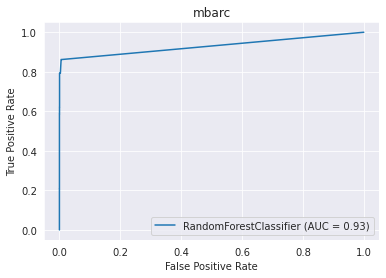

Precision: 0.75
Recall: 0.6923076923076923


In [177]:
# ra_mask = df_capitalist_species["relative_abundace"] > .005

# df_c_ra = df_capitalist_species[ra_mask]

for dataset in ["mbarc", "hmp", "gis", "dual_index", "zymo"]:
    
    X_type_1 = df_type_1_features
                                                 
    X_type_1 = X_type_1.replace([np.inf, -np.inf], np.nan)
    X_type_1 = X_type_1.dropna()
    
    mask_dataset = np.array([_.startswith(dataset) for _ in X_type_1["dataset"]])

    y = X_type_1["truth"]
    X_type_1 = X_type_1.loc[:, X_type_1.columns.difference(["assembly_accession", "dataset", "truth"])]
    
    X_type_1_train = X_type_1.loc[~mask_dataset, :]
    X_type_1_test =  X_type_1.loc[mask_dataset, :]
    y_train = y.loc[~mask_dataset]
    y_test = y.loc[mask_dataset]
    
    df_train = df_type_1_features[~mask_dataset]
    df_test = df_type_1_features[mask_dataset]  
    
    clf = RandomForestClassifier(random_state=42)

    clf.fit(X_type_1_train, y_train)
    
    
    clf_disp = plot_roc_curve(clf, X_type_1_test, y_test)
    plt.title(dataset)
    plt.show()
    
    y_test_preds = clf.predict(X_type_1_test)
    
    precision = y_test[y_test_preds].sum() / y_test_preds.sum()
    
    print("Precision:", precision)
    
    recall = y_test[y_test_preds].sum() / df_truth["dataset"].str.startswith(dataset).sum()
    
    print("Recall:", recall)
    
    
    fps = y_test_preds & ~y_test
    
    aa_fps = df_test.loc[fps, "assembly_accession"]
    
    tps = y_test_preds & y_test
    
    aa_tps = df_test.loc[tps, "assembly_accession"]
    
    fns = ~y_test_preds & y_test
    
    aa_fns = df_test.loc[fns, "assembly_accession"]  
    break
    
#     mask_ra = df_c_ra["dataset"].str.startswith(dataset)
    
#     df_masked = df_c_ra.loc[mask_ra, :]
    
#     precision_cap = df_masked["truth"].sum() / df_masked.shape[0]
    
#     print("Precision Capitalist:", precision_cap)
    
#     recall_cap = df_masked["truth"].sum() / df_truth["dataset"].str.startswith(dataset).sum()
    
#     print("Recall Capitalist:", recall_cap)

In [178]:
fn_mask = [_ in set(aa_fns) for _ in df_tax["assembly_accession"]]
fn_tax = list(df_tax.loc[fn_mask, "species"].values)
fn_tax = sorted(fn_tax)
for _ in fn_tax:
    print(_)

k__Bacteria;p__Acidobacteriota;c__Acidobacteriae;o__Acidobacteriales;f__Acidobacteriaceae;g__Terriglobus;s__Terriglobus_roseus_A
k__Bacteria;p__Acidobacteriota;c__Acidobacteriae;o__Acidobacteriales;f__Acidobacteriaceae;g__Terriglobus;s__Terriglobus_roseus_B
k__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Mycobacteriales;f__Mycobacteriaceae;g__Corynebacterium;s__Corynebacterium_glutamicum
k__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Mycobacteriales;f__Mycobacteriaceae;g__Corynebacterium;s__Corynebacterium_glutamicum_A
k__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Streptosporangiales;f__Streptosporangiaceae;g__Nocardiopsis;s__Nocardiopsis_dassonvillei
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus_pyogenes_A
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia_coli
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f

In [179]:
tp_mask = [_ in set(aa_tps) for _ in df_tax["assembly_accession"]]
tp_tax = list(df_tax.loc[tp_mask, "species"].values)
tp_tax = sorted(tp_tax)
for _ in tp_tax:
    print(_)

k__Archaea;p__Halobacteriota;c__Halobacteria;o__Halobacteriales;f__Natrialbaceae;g__Halovivax;s__Halovivax_ruber
k__Archaea;p__Halobacteriota;c__Halobacteria;o__Halobacteriales;f__Natrialbaceae;g__Natronobacterium;s__Natronobacterium_gregoryi
k__Archaea;p__Halobacteriota;c__Halobacteria;o__Halobacteriales;f__Natrialbaceae;g__Natronococcus;s__Natronococcus_occultus
k__Bacteria;p__Acidobacteriota;c__Acidobacteriae;o__Acidobacteriales;f__Acidobacteriaceae;g__Terriglobus;s__Terriglobus_roseus
k__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Mycobacteriales;f__Mycobacteriaceae;g__Segniliparus;s__Segniliparus_rotundus
k__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Atopobiaceae;g__Olsenella;s__Olsenella_uli
k__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Cytophagales;f__Cyclobacteriaceae;g__Echinicola;s__Echinicola_vietnamensis
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus_pyogenes
k__Bacteria;p__Firmic